# Notebook zum Experimentieren für die Kartenerstellung

In [21]:
import warnings
import psycopg2
import psycopg2.extras
import pandas as pd
import configparser
from shapely import wkt
import numpy as np
from scipy.interpolate import griddata
import folium
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from PIL import Image
import branca.colormap as cm
from osgeo import gdal, osr
from pathlib import Path
import os
import datetime

In [22]:
# get the current script directory path
currentScriptDirectoryPath = "pathto/mosmix_map_generator"  # geht im notebook nur absolut anscheinend
configFilePath = os.path.join(currentScriptDirectoryPath, 'config.ini')
config = configparser.ConfigParser()
config_result = config.read(configFilePath, encoding='utf8')

# Verbindung zur PostgreSQL-Datenbank herstellen
db_conn = f"host={config.get('connection', 'DB_HOST')} \
    port={config.get('connection', 'DB_PORT')} \
    dbname={config.get('connection', 'DB_NAME')} \
    user={config.get('connection', 'DB_USER')} \
    password={config.get('connection', 'DB_PASS')}"

### Erstmal Daten aus DB in Dataframe laden
### Dauert 10s

In [23]:
startTime = datetime.datetime.now()
warnings.filterwarnings('ignore', category=UserWarning) # um die nervige pandas warnung zu unterdrücken

conn = psycopg2.connect(db_conn)

# Alle Zeitpunkte holen
curs = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
curs.execute('SELECT DISTINCT(zeitpunkt) as zeitpunkt FROM dwd_mosmix ORDER BY zeitpunkt;')
zeitpunkte = [row['zeitpunkt'] for row in curs.fetchall()]
# Mach ich nicht mit sqlalchemy auch wenn es empfohlen wird
# Dauert mindestens 3x so lange wie mit psycopg2 
# Ein df pro Zeitpunkt mit allen Parametern
# db_conn = f"postgresql+psycopg2://{config.get('connection', 'DB_USER')}:{config.get('connection', 'DB_PASS')}@{config.get('connection', 'DB_HOST')}:{config.get('connection', 'DB_PORT')}/{config.get('connection', 'DB_NAME')}"
# conn = create_engine(db_conn) # Verbindung db mit sqalchemy

# Ein df pro Zeitpunkt mit allen Parametern
df_dict = {}
for zeitpunkt in zeitpunkte:
    # Abfrage der Daten für eine Station
    query = f"""
    SELECT stationsid, stationsname, ST_AsText(shape) as shape, temperatur, wolkenbedeckung, niederschlag_letzte_stunde, windboen_letzte_stunde, windgeschwindigkeit, windrichtung, druck_auf_meereshoehe
    FROM dwd_mosmix
    WHERE zeitpunkt = '{zeitpunkt}';
    """
    # Daten in DF laden
    df = pd.read_sql(query, con = conn)
    # Latitude und Longitude extrahieren
    df['geometry'] = df['shape'].apply(wkt.loads)
    df['latitude'] = df['geometry'].apply(lambda geom: geom.y)
    df['longitude'] = df['geometry'].apply(lambda geom: geom.x)
    df = df.drop(columns='geometry')
    # Dict hinzufügen
    df_dict[f'{zeitpunkt}'] = df

# Verbindung schließen
conn.close()

scriptDuration = str(datetime.datetime.now() - startTime).split(':')[2]
print('scriptDuration: ',scriptDuration)

warnings.resetwarnings()

scriptDuration:  10.241806


### Hier wird interpoliert
#### Linear hat sich als am besten herausgestellt
#### Speicherung tifs

In [24]:
# Koordinaten und Werte
stationen = df[['latitude','longitude','stationsname', 'stationsid', 'temperatur']].values
temerature = df['temperatur'].values

steps_gitter = 500
# Gitter für Interpolation definieren
grid_lon = np.linspace(df['longitude'].min(), df['longitude'].max(), steps_gitter)
grid_lat = np.linspace(df['latitude'].min(), df['latitude'].max(), steps_gitter)
rasterpoints = [(lat, lon) for lat in grid_lat for lon in grid_lon]
# print(rasterpoints)
grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)
points = np.vstack((df['latitude'], df['longitude'])).T
# Interpolieren
grid_temp = griddata(points, temerature, (grid_lat, grid_lon), method='linear') # auswahl aus {‘linear’, ‘nearest’, ‘cubic’}, linear sieht für mich am besten aus

# Werte runden
# grid_temp = np.round(grid_temp)

# Temperaturwerte für Visualisierung normalisieren
norm = Normalize(vmin=np.nanmin(grid_temp), vmax=np.nanmax(grid_temp))
cmap = plt.get_cmap('coolwarm')
grid_temp_normalized = norm(grid_temp)
rgba_grid = cmap(grid_temp_normalized)

# NaN-Werte transparent
alpha_channel = np.where(np.isnan(grid_temp), 0, 1)
rgba_grid[..., -1] = alpha_channel

# Bild aus dem Raster erstellen
image = (rgba_grid * 255).astype(np.uint8)
image = np.flipud(image)    # Raster läuft von oben nach unten, Bilder von unten nach oben, deshalb umsrehen
img = Image.fromarray(image)
if not Path('./raster').is_dir():
    os.mkdir('./raster')
img.save('raster/temperature_raster.tif')
img.save('raster/temperature_raster.png')


### Georeferenziertes GeoTIFF mit Farbskala

In [25]:
# GeoTiff erstellen mit Farbskala

output_file = 'raster/temperature_raster_geotiff.tif'

# Treiber für GeoTIFF
driver = gdal.GetDriverByName('GTiff')

# GeoTIFF erstellen
dataset = driver.Create(output_file, grid_temp.shape[1], grid_temp.shape[0], 4, gdal.GDT_Float32)

# Rasterdaten für jedes Band schreiben
for i in range(4):  # RGBA hat 4 Kanäle
    dataset.GetRasterBand(i+1).WriteArray(image[:,:,i])

# Geotransformation
x_min = df['longitude'].min()
x_max = df['longitude'].max()
y_min = df['latitude'].min()
y_max = df['latitude'].max()
pixel_width = (x_max - x_min) / steps_gitter
pixel_height = (y_max - y_min) / steps_gitter

# Geotransformation:
# top left x, w-e pixel resolution, rotation, top left y, rotation, n-s pixel resolution (negativ, weil von oben nach unten)
dataset.SetGeoTransform((x_min, pixel_width, 0, y_max, 0, -pixel_height))

# Projektion (WGS84)
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)  # WGS84
dataset.SetProjection(srs.ExportToWkt())

# Datei schließen
dataset.FlushCache()
dataset = None

### Georeferenziertes GeoTIFF mit Daten als Grauskala

In [26]:
# Geotiff erstellen mit Daten
output_file = 'raster/temperature_values_geotiff_Daten.tif'

# Array vertikal flippen
grid_temp_flipped = np.flipud(grid_temp)

# Treiber für GeoTIFF
driver = gdal.GetDriverByName('GTiff')

# GeoTIFF erstellen
dataset = driver.Create(output_file, grid_temp_flipped.shape[1], grid_temp_flipped.shape[0], 1, gdal.GDT_Float32)

# Temperaturdaten ins erste Band schreiben
dataset.GetRasterBand(1).WriteArray(grid_temp_flipped)

# Geotransformation
x_min = df['longitude'].min()
x_max = df['longitude'].max()
y_min = df['latitude'].min()
y_max = df['latitude'].max()
pixel_width = (x_max - x_min) / grid_temp_flipped.shape[1]
pixel_height = (y_max - y_min) / grid_temp_flipped.shape[0]

dataset.SetGeoTransform((x_min, pixel_width, 0, y_max, 0, -pixel_height))

# Projektion (WGS84)
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)  # WGS84
dataset.SetProjection(srs.ExportToWkt())

# Datei schließen
dataset.FlushCache()
dataset = None

### Interpolation mit Stationen zusammen veranschaulichen


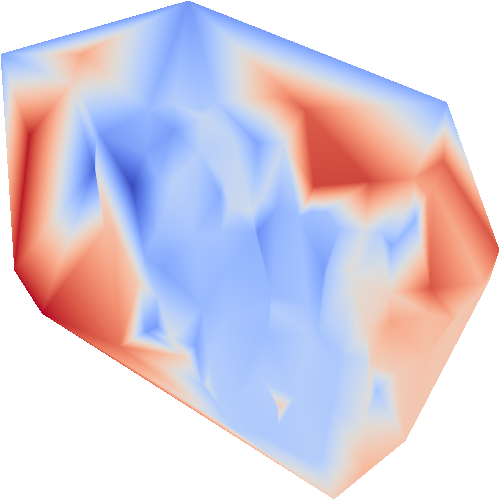

In [27]:
m = folium.Map(location=[54.5, 9.5], zoom_start=7)
# Rasterpunkte zur Karte hinzufügen
for latitude, longitude, name, stationsid, temperatur in stationen:
    folium.CircleMarker(
        location=[latitude, longitude],
        popup=f"ID: {stationsid}<br>Name: {name}<br>Temperatur: {temperatur}<br>latitude: {latitude}<br>longitude: {longitude}",
        radius=4,
        color="black",
        stroke=False,
        fill=True,
        fill_opacity=1,
        opacity=1
    ).add_to(m)

# for lat, lon in rasterpoints:
#     folium.CircleMarker(
#         location=[lat, lon],
#         radius=0.2,
#         color="red",
#         stroke=False,
#         fill=True,
#         fill_opacity=1,
#         opacity=1
#     ).add_to(m)

# Füge das Bild als Overlay hinzu
img_overlay = folium.raster_layers.ImageOverlay(
    name='Temperature Raster',
    image='raster/temperature_raster.png',
    bounds=[[min(df['latitude']), min(df['longitude'])], [max(df['latitude']), max(df['longitude'])]],
    opacity=0.6,
    interactive=True,
    cross_origin=False,
    zindex=1,
)
img_overlay.add_to(m)

# Erstelle eine Colorbar
colormap = cm.LinearColormap(colors=['blue', 'red'], vmin=np.nanmin(grid_temp), vmax=np.nanmax(grid_temp), caption='Temperature (°C)')
colormap.add_to(m)

folium.LayerControl().add_to(m)
m